In [1]:
import numpy as np
import pandas as pd
from neurodsp.sim import sim_noisy_bursty_oscillator
from neurodsp.filt import filter_signal
from bycycle.features import compute_features

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
plt.style.use('Cole_2018.mplstyle')

from config import config_sim

# A. Raw data

In [2]:
# Simulate signal
n_seconds = 10
fs = config_sim['fs']
ratio_osc_var = 2
prob_leave_burst = 0
prob_enter_burst = 1
rdsym = .5

np.random.seed(0)
sig = sim_noisy_bursty_oscillator(n_seconds, fs, config_sim['freq_osc'],
                                  noise_generator='filtered_powerlaw',
                                  noise_args={'exponent': -2, 'f_range':config_sim['f_range_noise'],
                                              'filter_order':config_sim['filter_order_noise']},
                                  rdsym=rdsym, cycle_features=config_sim['cycle_features'],
                                  ratio_osc_var=ratio_osc_var,
                                  prob_enter_burst=prob_enter_burst, prob_leave_burst=prob_leave_burst)

/Users/scott/anaconda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/scott/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/scott/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpre

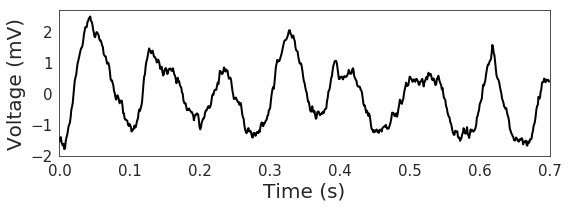

In [3]:
# Plot raw data
%matplotlib inline
t = np.arange(0, len(sig)/fs, 1/fs)
tlim = (2.5, 3.2)
tidx = np.logical_and(t >= tlim[0], t < tlim[1])

plt.figure(figsize=(8,3))
plt.plot(t[tidx] - tlim[0], sig[tidx], 'k')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.xlim(0, tlim[1] - tlim[0])
plt.yticks(np.linspace(-2,2,5))
plt.tight_layout()
plt.savefig('figs/1A_rawlfp.png')

# B. Lowpass filter

In [4]:
# Apply 40Hz lowpass filters
sig_filt = filter_signal(sig, fs, 'lowpass', config_sim['lowpass_fc'],
                         n_seconds=config_sim['lowpass_n_seconds'], remove_edge_artifacts=False)

Transition bandwidth is 13.7 Hz. Pass/stop bandwidth is 40 Hz


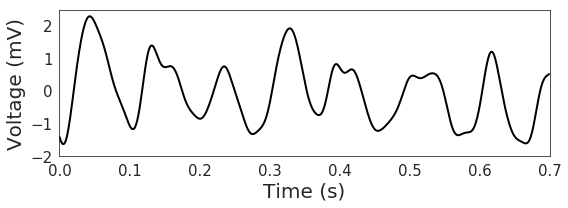

In [5]:
# Limit LFP to timeframe of interest

plt.figure(figsize=(8,3))
plt.plot(t[tidx] - tlim[0], sig_filt[tidx], 'k')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.yticks(np.linspace(-2,2,5))
plt.xlim(0, tlim[1] - tlim[0])
plt.tight_layout()
plt.savefig('figs/1B_broad_bandpass.png')

# C. Determine zero-crossings in narrow bandpass

In [7]:
# Narrow bandpass of LFP
from bycycle.cyclepoints import _fzerofall, _fzerorise

sig_narrow = filter_signal(sig_filt, fs, 'bandpass', config_sim['f_range'], n_seconds=.75,
                           remove_edge_artifacts=False)

# Determine zerocrossings
zeroriseN = _fzerorise(sig_narrow)
zerofallN = _fzerofall(sig_narrow)

Transition bandwidth is 2.0 Hz. Pass/stop bandwidth is 8 Hz


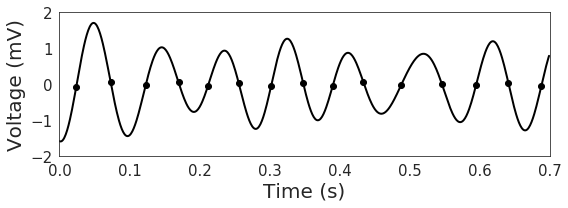

In [8]:
# Limit zerocrossings to time of interest
zeroriseN = zeroriseN[(zeroriseN/fs >= tlim[0]) &(zeroriseN/fs < tlim[1])]
zerofallN = zerofallN[(zerofallN/fs >= tlim[0]) &(zerofallN/fs < tlim[1])] 

# Visualize zerocrossings on bandpass data
plt.figure(figsize=(8,3))
plt.plot(t[tidx] - tlim[0], sig_narrow[tidx], 'k')
plt.plot(t[zeroriseN] - tlim[0], sig_narrow[zeroriseN], 'ko')
plt.plot(t[zerofallN] - tlim[0], sig_narrow[zerofallN], 'ko')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.yticks(np.linspace(-2,2,5))
plt.xlim(0, tlim[1] - tlim[0])
plt.tight_layout()
plt.savefig('figs/1C_zerocrossings.png')

# D. Determine timepoints of oscillatory extrema

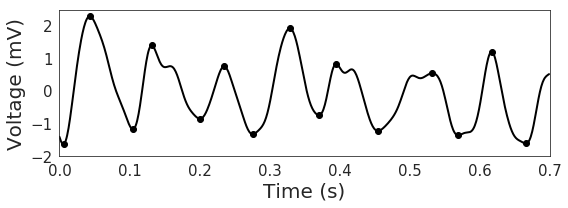

In [10]:
# Find peaks and troughs
from bycycle.cyclepoints import find_extrema
Ps, Ts = find_extrema(sig_filt, fs, config_sim['f_range'], filter_kwargs={'N_seconds': .75})

# Limit extrema to time of interest
Ps_plt = Ps[(Ps/fs >= tlim[0]) & (Ps/fs < tlim[1])]
Ts_plt = Ts[(Ts/fs >= tlim[0]) & (Ts/fs < tlim[1])]

plt.figure(figsize=(8,3))
plt.plot(t[tidx] - tlim[0], sig_filt[tidx], 'k')
plt.plot(t[Ps_plt] - tlim[0], sig_filt[Ps_plt], 'ko')
plt.plot(t[Ts_plt] - tlim[0], sig_filt[Ts_plt], 'ko')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.yticks(np.linspace(-2,2,5))
plt.xlim(0, tlim[1] - tlim[0])
plt.tight_layout()
plt.savefig('figs/1D_peaks_and_troughs.png')

# E. Determine flank midpoints in each cycle

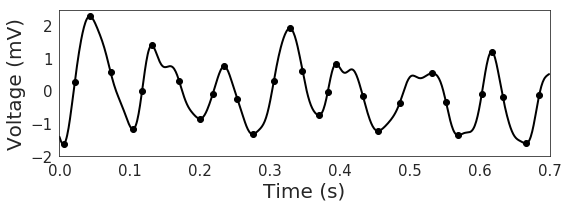

In [11]:
# Find zerocrossings
from bycycle.cyclepoints import find_zerox
zeroxR, zeroxD = find_zerox(sig_filt, Ps, Ts)

# Limit zerocrossings to time of interest
zeroxR_plt = zeroxR[(zeroxR/fs >= tlim[0]) & (zeroxR/fs < tlim[1])]
zeroxD_plt = zeroxD[(zeroxD/fs >= tlim[0]) & (zeroxD/fs < tlim[1])]

# Plot zerocrossings together with extrema
plt.figure(figsize=(8,3))
plt.plot(t[tidx] - tlim[0], sig_filt[tidx], 'k')
plt.plot(t[Ps_plt] - tlim[0], sig_filt[Ps_plt], 'ko')
plt.plot(t[Ts_plt] - tlim[0], sig_filt[Ts_plt], 'ko')
plt.plot(t[zeroxR_plt] - tlim[0], sig_filt[zeroxR_plt], 'ko')
plt.plot(t[zeroxD_plt] - tlim[0], sig_filt[zeroxD_plt], 'ko')
plt.xlim((0,1))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.yticks(np.linspace(-2,2,5))
plt.xlim(0, tlim[1] - tlim[0])
plt.tight_layout()
plt.savefig('figs/1E_flank_midpoints.png')

# F. Plot lines for computing symmetries

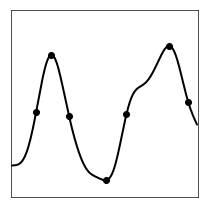

In [12]:
tlim2 = (3.08, 3.25)
tidx2 = np.logical_and(t >= tlim2[0], t < tlim2[1])

# Limit extrema to time of interest
Ps_plt = Ps[(Ps/fs >= tlim2[0]) & (Ps/fs < tlim2[1])]
Ts_plt = Ts[(Ts/fs >= tlim2[0]) & (Ts/fs < tlim2[1])]

# Limit zerocrossings to time of interest
zeroxR_plt = zeroxR[(zeroxR/fs >= tlim2[0]) & (zeroxR/fs < tlim2[1])]
zeroxD_plt = zeroxD[(zeroxD/fs >= tlim2[0]) & (zeroxD/fs < tlim2[1])]

# Plot zerocrossings together with extrema
plt.figure(figsize=(3,3))
plt.plot(t[tidx2] - tlim2[0], sig_filt[tidx2], 'k')
plt.plot(t[Ps_plt] - tlim2[0], sig_filt[Ps_plt], 'ko')
plt.plot(t[Ts_plt] - tlim2[0], sig_filt[Ts_plt], 'ko')
plt.plot(t[zeroxR_plt] - tlim2[0], sig_filt[zeroxR_plt], 'ko')
plt.plot(t[zeroxD_plt] - tlim2[0], sig_filt[zeroxD_plt], 'ko')
plt.yticks([])
plt.xticks([])
plt.ylim((-2, 2.2))
plt.xlim(0, tlim2[1] - tlim2[0])

plt.tight_layout()
plt.savefig('figs/1F_symmetries.png')

# G. Analysis table

In [14]:
# Compute cycle features
osc_kwargs = {'amplitude_fraction_threshold':0,
              'amplitude_consistency_threshold':.6,
              'period_consistency_threshold':.75,
              'monotonicity_threshold':.8,
              'N_cycles_min':3}

df = compute_features(sig_filt, fs, config_sim['f_range'], center_extrema='T',
                      burst_detection_kwargs = osc_kwargs)

In [15]:
# Format table
cols_rename = {'sample_trough': 'Trough time',
               'volt_amp': 'Amplitude',
               'period': 'Period',
               'time_rdsym': 'rdsym',
               'time_ptsym': 'ptsym'}
df_show = df.rename(columns=cols_rename)
df_show['Trough time'] = df_show['Trough time']/1000 - tlim[0]
df_show = df_show[(df_show['Trough time'] > 0.05) & (df_show['Trough time'] <= tlim[1] - tlim[0] - .05)].reset_index(drop=True)
df_show = df_show[list(cols_rename.values())]

styles = [
    dict(selector="th", props=[("font-size", "200%"),
                               ("text-align", "center")]),
    dict(selector="td", props=[("font-size", "200%"),
                               ("text-align", "right")])
]

# df_show.style.set_precision(2)
html = (df_show.style.\
        set_table_styles(styles).\
        hide_index().\
        set_precision(2))
html

Trough time,Amplitude,Period,rdsym,ptsym
0.1,3,89,0.3,0.53
0.2,1.9,103,0.33,0.52
0.28,2.7,94,0.56,0.4
0.37,2.1,66,0.38,0.53
0.46,1.9,137,0.56,0.49
0.57,2.2,85,0.56,0.56
